On perlmutter: use kernel pytorch-1.13.1

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pickle
plt.style.use("../science.mplstyle")

import os
import torch

from numba import cuda 

from helpers.plotting import *
from helpers.evaluation import *
from helpers.data_transforms import clean_data

seed = 8

In [60]:
"""
# computing

device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)
"""

'\n# computing\n\ndevice = cuda.get_current_device()\ndevice.reset()\n\n# set the number of threads that pytorch will use\ntorch.set_num_threads(2)\n\n# set gpu device\ndevice = torch.device( "cuda" if torch.cuda.is_available() else "cpu")\nprint( "Using device: " + str( device ), flush=True)\n'

In [104]:
# load in the data

bands = ["SBL", "SR", "SBH"]
data_dict = {}

working_dir = "/pscratch/sd/r/rmastand/dimuonAD/projects/logit_08_22/"
#\working_dir = "/global/u1/r/rmastand/dimuonAD/projects/powerscaler_0813/"


flow_id = "double_1"
particle_type = "upsilon"

project_id = f"lowmass_{particle_type}_nojet"
config_id = "CATHODE_8"

flow_training_dir = os.path.join(f"{working_dir}/models", f"{project_id}/{flow_id}/{config_id}")
#

with open(f"{flow_training_dir}/flow_samples", "rb") as infile: 
    data_dict = pickle.load(infile)
    
with open(f"{working_dir}/processed_data/{project_id}_test_band_data", "rb") as infile: 
    test_dict = pickle.load(infile)
    
with open(f"{working_dir}/processed_data/{project_id}_samesign_band_data", "rb") as infile: 
    samesign_dict = pickle.load(infile)
    

with open(f"{flow_training_dir}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    print(configs)


feature_set = ['dimu_pt', 'dimu_eta', 'dimu_mass']



In [105]:
feature_set = ['dimu_pt', 'dimu_eta', 'dimu_mass']



## Evaluate the SB Samples

In [106]:
# Assemble the test set -- consists of both SB and SR



num_events_test_SBL = test_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_test_SR = test_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_test_SBH = test_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_samesign = samesign_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]

test_events_SBL = np.empty((num_events_test_SBL, len(feature_set)))
test_events_SR = np.empty((num_events_test_SR, len(feature_set)))
test_events_SBH = np.empty((num_events_test_SBH, len(feature_set)))

test_events_samesign = np.empty((num_events_samesign, len(feature_set)))

for i, feat in enumerate(feature_set):
    
    test_events_SBL[:,i] = test_dict["SBL"]["s_inj_data"][feat].reshape(-1,)
    test_events_SR[:,i] = test_dict["SR"]["s_inj_data"][feat].reshape(-1,)
    test_events_SBH[:,i] = test_dict["SBH"]["s_inj_data"][feat].reshape(-1,)
    
    
    loc_arr = np.concatenate((samesign_dict["SR"]["s_inj_data"][feat], samesign_dict["SBL"]["s_inj_data"][feat], samesign_dict["SBH"]["s_inj_data"][feat]))
    test_events_samesign[:,i] = loc_arr.reshape(-1,)

test_events_SB = np.vstack([test_events_SBL, test_events_SBH ])
print(data_dict["SR"].shape)
    
print(f"Total number of test events: {test_events_SR.shape[0]+test_events_SBL.shape[0]+test_events_SBH.shape[0]}. {test_events_SR.shape[0]} in SR, {test_events_SBL.shape[0]+test_events_SBH.shape[0]} in SB.")


(97583, 3)
Total number of test events: 34998. 9605 in SR, 25393 in SB.


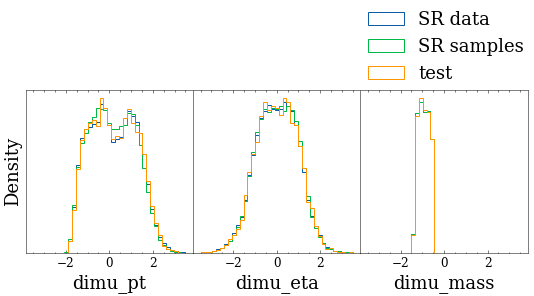

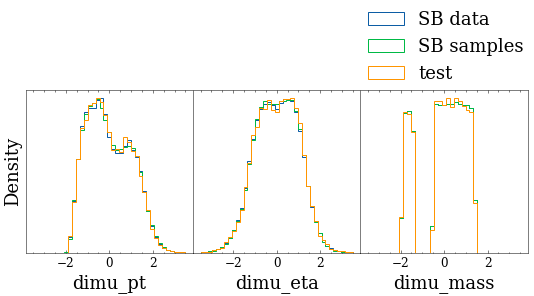

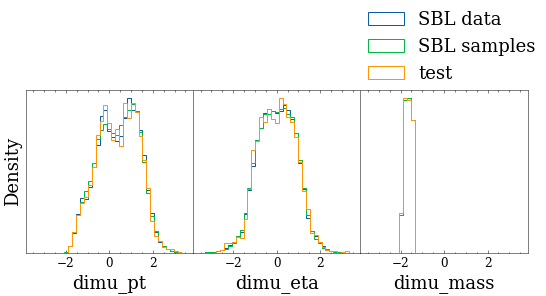

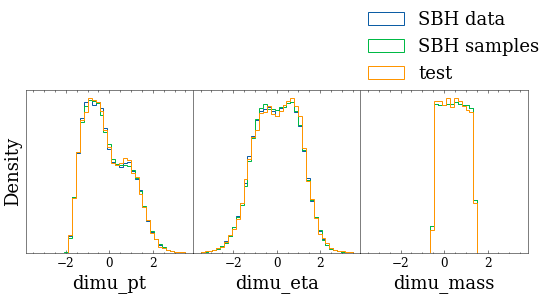

In [107]:
plot_bound = 3.5
log_scale = False


data_dict["SR_samples"] = clean_data(data_dict["SR_samples"])
data_dict["SBL_samples"] = clean_data(data_dict["SBL_samples"])
data_dict["SBH_samples"] = clean_data(data_dict["SBH_samples"])

hist_all_features_array([data_dict["SR"], data_dict["SR_samples"], test_events_SR], ["SR data", "SR samples", "test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([data_dict["SB"], data_dict["SB_samples"], test_events_SB], ["SB data", "SB samples", "test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([data_dict["SBL"], data_dict["SBL_samples"], test_events_SBL], ["SBL data", "SBL samples", "test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([data_dict["SBH"], data_dict["SBH_samples"],test_events_SBH], ["SBH data", "SBH samples", "test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)


# Fancier things below

Wasserstein distance

In [108]:

wds = get_1d_wasserstein_distances(data_dict["SB"], data_dict["SB_samples"])


for i, wd in enumerate(wds):
    print(f"Feature {i} distance: {wd}")
print(f"Total distance: {np.mean(wds)}")




wds = get_1d_wasserstein_distances(np.random.normal(size = data_dict["SB"].shape), np.random.normal(size = data_dict["SB"].shape))


for i, wd in enumerate(wds):
    print(f"Feature {i} distance: {wd}")
print(f"Total distance: {np.mean(wds)}")




Feature 0 distance: 0.006745133578855437
Feature 1 distance: 0.00862796054145823
Feature 2 distance: 0.0
Total distance: 0.005124364706771222
Feature 0 distance: 0.0028574300802170095
Feature 1 distance: 0.004866723172268274
Feature 2 distance: 0.0027204141010424526
Total distance: 0.003481522451175912


Binary classifier

In [109]:
n_estimators = 100 # number of boosting stages
max_depth = 20 # max depth of individual regression estimators; related to complexity
learning_rate = 0.1
subsample = 0.5 # fraction of samples to be used for fitting the individual base learners
early_stopping_rounds = 10 # stop training BDT is validation loss doesn't improve after this many rounds


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import xgboost as xgb

0


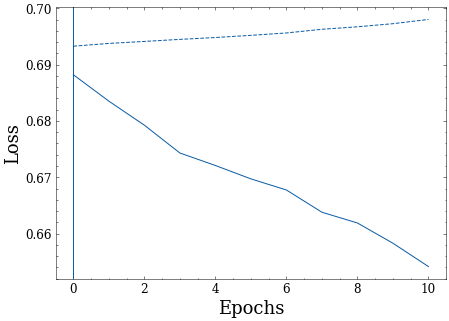

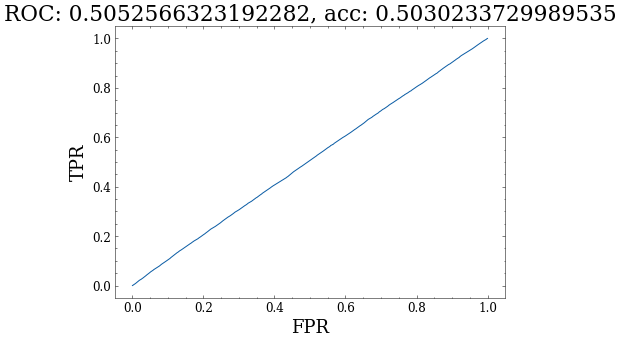


1


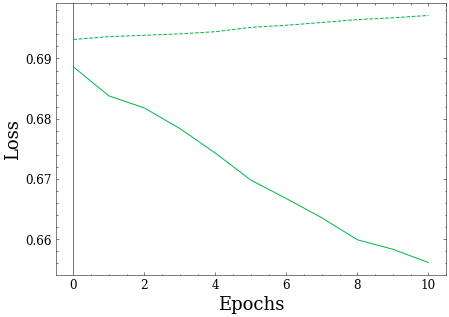

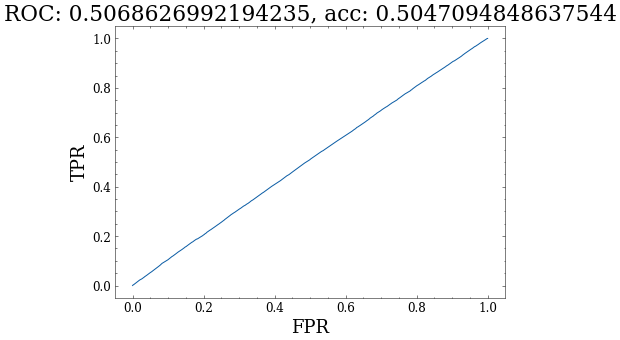


2


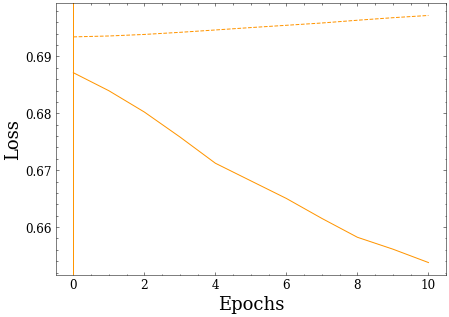

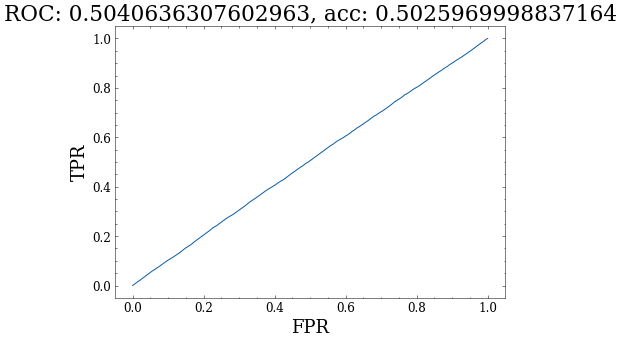


0.5053943207663161 0.0011468550158488014
[0.5052566323192282, 0.5068626992194235, 0.5040636307602963]


In [110]:


SB_data_train, SB_data_test, SB_samples_train, SB_samples_test = train_test_split(data_dict["SB"], data_dict["SB_samples"], 
                                                                                  test_size=0.1, random_state=42)
SB_samples_train = clean_data(SB_samples_train)
SB_samples_test = clean_data(SB_samples_test)

X_train = np.vstack([SB_data_train, SB_samples_train])

Y_train = np.vstack([np.ones((SB_data_train.shape[0], 1)), np.zeros((SB_samples_train.shape[0], 1))])

X_val = np.vstack([SB_data_test, SB_samples_test])
Y_val = np.vstack([np.ones((SB_data_test.shape[0], 1)), np.zeros((SB_samples_test.shape[0], 1))])

n_runs = 3
auc_list = []
acc_list = []




for i in range(n_runs):
    
    print(i)

    

    eval_set = [(X_train, Y_train), (X_val, Y_val)]

    bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                              subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                              objective='binary:logistic', 
                                      random_state = i, eval_metric="logloss")

    bst_i.fit(X_train, Y_train,  eval_set=eval_set,   verbose=False)
    results_f = bst_i.evals_result()
    losses = results_f["validation_0"]["logloss"]
    losses_val = results_f["validation_1"]["logloss"]
    best_epoch = bst_i.best_iteration
    
    plt.figure()
    plt.plot(losses, color = f"C{i}")
    plt.plot(losses_val, color = f"C{i}", linestyle = "dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.axvline(best_epoch, color = f"C{i}")
    plt.show()

    loc_scores =  bst_i.predict_proba(X_val, iteration_range=(0,bst_i.best_iteration))[:,1]

    loc_auc = roc_auc_score(Y_val, loc_scores)
    loc_acc = accuracy_score(Y_val, np.round(loc_scores))
    fpr, tpr, _ = roc_curve(Y_val, loc_scores)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(f"ROC: {loc_auc}, acc: {loc_acc}")
    plt.show()
    
    auc_list.append(loc_auc)
    
    print()

print(np.mean(auc_list), np.std(auc_list))

print(auc_list)


0


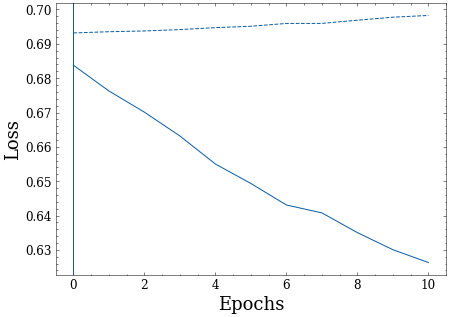

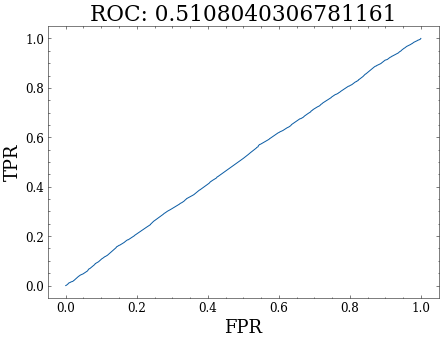


1


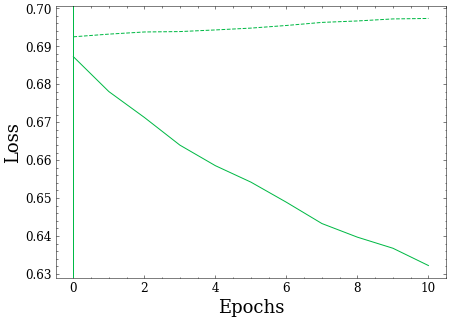

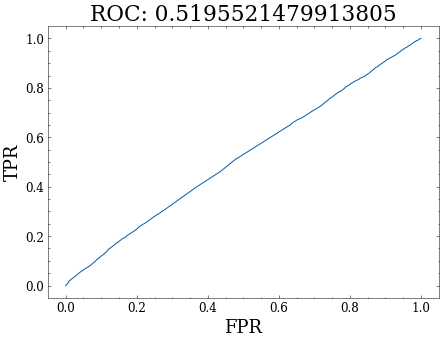


2


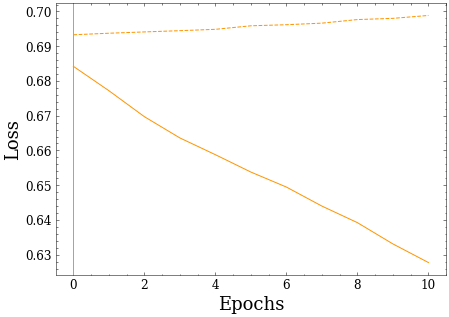

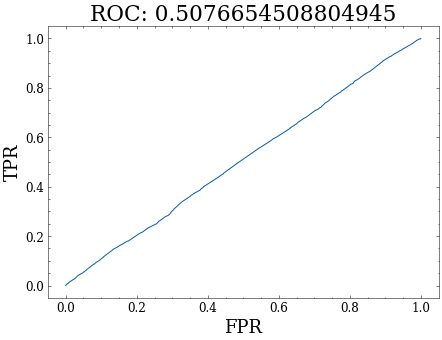


0.5126738765166637 0.005029621234674741
[0.5108040306781161, 0.5195521479913805, 0.5076654508804945]


In [111]:




SB_data_train, SB_data_test, SB_samples_train, SB_samples_test = train_test_split(data_dict["SBL"], data_dict["SBL_samples"], 
                                                                                  test_size=0.1, random_state=42)

X_train = np.vstack([SB_data_train, SB_samples_train])
Y_train = np.vstack([np.ones((SB_data_train.shape[0], 1)), np.zeros((SB_samples_train.shape[0], 1))])

X_val = np.vstack([SB_data_test, SB_samples_test])
Y_val = np.vstack([np.ones((SB_data_test.shape[0], 1)), np.zeros((SB_samples_test.shape[0], 1))])

n_runs = 3
auc_list = []


for i in range(n_runs):
    
    print(i)

    

    eval_set = [(X_train, Y_train), (X_val, Y_val)]

    bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                              subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                              objective='binary:logistic', 
                                      random_state = i, eval_metric="logloss")

    bst_i.fit(X_train, Y_train,  eval_set=eval_set,   verbose=False)
    results_f = bst_i.evals_result()
    losses = results_f["validation_0"]["logloss"]
    losses_val = results_f["validation_1"]["logloss"]
    best_epoch = bst_i.best_iteration
    
    plt.figure()
    plt.plot(losses, color = f"C{i}")
    plt.plot(losses_val, color = f"C{i}", linestyle = "dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.axvline(best_epoch, color = f"C{i}")
    plt.show()

    loc_scores =  bst_i.predict_proba(X_val, iteration_range=(0,bst_i.best_iteration))[:,1]

    loc_auc = roc_auc_score(Y_val, loc_scores)
    fpr, tpr, _ = roc_curve(Y_val, loc_scores)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(loc_auc))
    plt.show()
    
    auc_list.append(loc_auc)
    
    print()

print(np.mean(auc_list), np.std(auc_list))

print(auc_list)


0


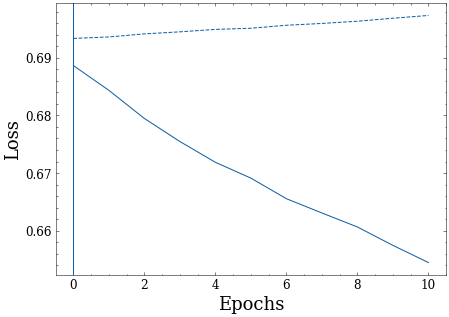

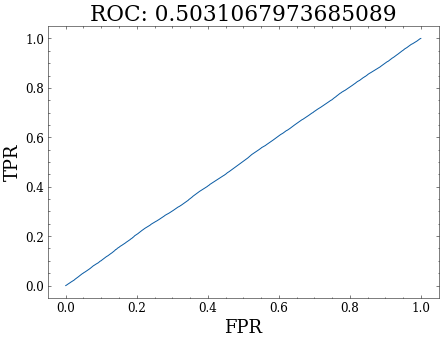


1


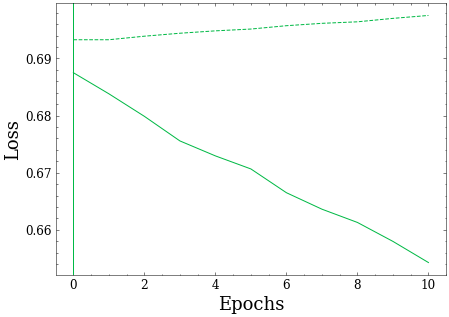

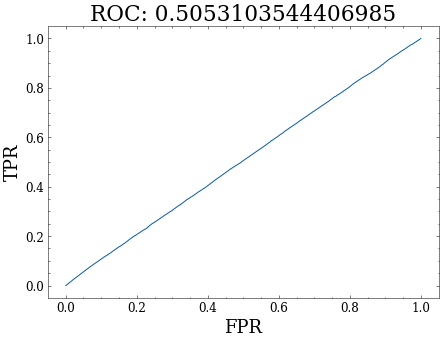


2


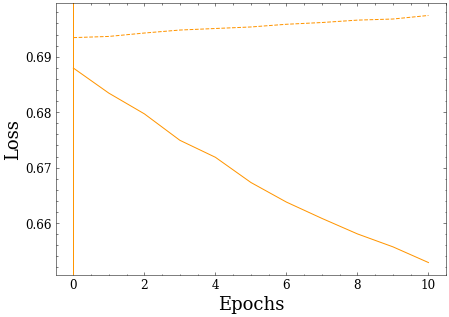

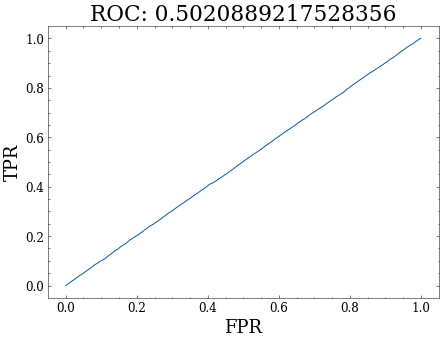


0.503502024520681 0.0013445099521060782
[0.5031067973685089, 0.5053103544406985, 0.5020889217528356]


In [112]:



SB_data_train, SB_data_test, SB_samples_train, SB_samples_test = train_test_split(data_dict["SBH"], data_dict["SBH_samples"], 
                                                                                  test_size=0.1, random_state=42)

X_train = np.vstack([SB_data_train, SB_samples_train])
Y_train = np.vstack([np.ones((SB_data_train.shape[0], 1)), np.zeros((SB_samples_train.shape[0], 1))])

X_val = np.vstack([SB_data_test, SB_samples_test])
Y_val = np.vstack([np.ones((SB_data_test.shape[0], 1)), np.zeros((SB_samples_test.shape[0], 1))])

n_runs = 3
auc_list = []


for i in range(n_runs):
    
    print(i)

    

    eval_set = [(X_train, Y_train), (X_val, Y_val)]

    bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                              subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                              objective='binary:logistic', 
                                      random_state = i, eval_metric="logloss")

    bst_i.fit(X_train, Y_train,  eval_set=eval_set,   verbose=False)
    results_f = bst_i.evals_result()
    losses = results_f["validation_0"]["logloss"]
    losses_val = results_f["validation_1"]["logloss"]
    best_epoch = bst_i.best_iteration
    
    plt.figure()
    plt.plot(losses, color = f"C{i}")
    plt.plot(losses_val, color = f"C{i}", linestyle = "dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.axvline(best_epoch, color = f"C{i}")
    plt.show()

    loc_scores =  bst_i.predict_proba(X_val, iteration_range=(0,bst_i.best_iteration))[:,1]

    loc_auc = roc_auc_score(Y_val, loc_scores)
    fpr, tpr, _ = roc_curve(Y_val, loc_scores)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(loc_auc))
    plt.show()
    
    auc_list.append(loc_auc)
    
    print()

print(np.mean(auc_list), np.std(auc_list))

print(auc_list)


## 